In [1]:
%matplotlib notebook
#%matplotlib widget

import copy
import json
import numpy as np
import requests

from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os import environ, path

In [2]:
out_dir = path.join(environ.get("HOME"), "Chaos", "DL")
out_file_name = "cov19"

In [3]:
euro = {"at": "Austria", "be": "Belgium", "ba": "Bosnia and Herzegovina", "bg": "Bulgaria",
        "hr": "Croatia", "cy": "Cyprus", "cz": "Czechia", "dk": "Denmark", "ee": "Estonia",
        "fi": "Finland", "fr": "France", "de": "Germany", "gr": "Greece", "hu": "Hungary",
        "ie": "Ireland", "it": "Italy", "lv": "Latvia", "li": "Liechtenstein",
        "lt": "Lithuania", "lu": "Luxembourg", "nl": "Netherlands", "no": "Norway",
        "pl": "Poland", "pt": "Portugal", "ro": "Romania", "rs": "Serbia", "sk": "Slovakia",
        "si": "Slovenia", "es": "Spain", "se": "Sweden", "ch": "Switzerland",
        "gb": "United Kingdom"}

In [4]:
regions = {"amro": ["us"],
           "euro": euro.keys()}

In [5]:
population = {"at": 8901000, "be": 11431000, "ba": 3531000, "bg": 6951000,
        "hr": 4190000, "cy": 1189000, "cz": 10637000, "dk": 5822000, "ee": 1323000,
        "fi": 5517000, "fr": 66993000, "de": 83166000, "gr": 10277000, "hu": 9773000,
        "ie": 4761000, "it": 60260000, "lv": 1934000, "li": 38000,
        "lt": 2794000, "lu": 626000, "nl": 17290000, "no": 5367000,
        "pl": 38386000, "pt": 10600000, "ro": 20121000, "rs": 7057000, "sk": 5450000,
        "si": 2064000, "es": 47100000, "se": 10327000, "ch": 8601000,
        "gb": 66435000, "us": 328000000}

In [6]:
cases_day_description = {"key": ["unix_timestamp"],
                         "values": ["cases_per_day_confirmed", "cases_cumulative",
                                    "cases_cumulative_percent_population",
                                    "deaths_per_day_confirmed", "deaths_cumulative",
                                    "deaths_cumulative_permil_population"]}
full_data = {"cases_per_day_data_description": cases_day_description,
             "countries": {}}


In [7]:
# data dimensions; (1) timestamp, (2), region, (3) deaths, (4) cumulative deaths,
# (5) deaths last 7 days, (6) Deaths Last 7 Days Change, (7) Deaths Per Million, (8) Confirmed,
# (9) Cumulative confirmed, (10) Cases Last 7 Days, (11) Cases Last 7 Days Change,
# (12) Cases Per Million
furl = "https://covid19.who.int/page-data/region/%s/country/%s/page-data.json"


In [8]:
# Fetch and convert data from all regions of interest
for reg in regions:
    for country_id in regions[reg]:
        country_name = "United States"
        region = "america"
        if country_id != "us":
            country_name = euro[country_id]
            region = "euro"

        curr_url = furl % (reg, country_id)
        res = requests.get(curr_url)
        print("Fetching country: '%s/%s' at \n\t%s" % (country_id, country_name, curr_url))
        data = json.loads(res.text)

        # Reduce to "timestamp: [confirmed, confirmed_cumulative,
        #                        case_cumulative_percent_population,
        #                        deaths, deaths_cumulative, death_cumulative_permil_population]"
        curr_country = {}
        curr_data = data["result"]["pageContext"]["countryGroup"]["data"]["rows"]
        curr_perc_pop = population[country_id]/100
        curr_perm_pop = population[country_id]/1000
        for i in curr_data:
            case_perc_pop = round(i[8]/curr_perc_pop, 3)
            death_perm_pop = round(i[3]/curr_perm_pop, 3)

            curr_country[i[0]] = [i[7], i[8], case_perc_pop, i[2], i[3], death_perm_pop]

        print("\tLatest cases: %s" % curr_country[list(curr_country.keys())[-1]])
        full_data["countries"][country_id] = {"country_name": country_name,
                                              "region": region,
                                              "population": population[country_id],
                                              "cases": curr_country}


Fetching country: 'us/United States' at 
	https://covid19.who.int/page-data/region/amro/country/us/page-data.json
	Latest cases: [227369, 20870913, 6.363, 3533, 354286, 1.08]
Fetching country: 'at/Austria' at 
	https://covid19.who.int/page-data/region/euro/country/at/page-data.json
	Latest cases: [2255, 368780, 4.143, 77, 6403, 0.719]
Fetching country: 'be/Belgium' at 
	https://covid19.who.int/page-data/region/euro/country/be/page-data.json
	Latest cases: [0, 652735, 5.71, 0, 19827, 1.734]
Fetching country: 'ba/Bosnia and Herzegovina' at 
	https://covid19.who.int/page-data/region/euro/country/ba/page-data.json
	Latest cases: [564, 113392, 3.211, 32, 4211, 1.193]
Fetching country: 'bg/Bulgaria' at 
	https://covid19.who.int/page-data/region/euro/country/bg/page-data.json
	Latest cases: [1310, 205390, 2.955, 67, 7902, 1.137]
Fetching country: 'hr/Croatia' at 
	https://covid19.who.int/page-data/region/euro/country/hr/page-data.json
	Latest cases: [1896, 216286, 5.162, 44, 4223, 1.008]
Fetc

In [9]:
# Save data structure to json file
fn = path.join(out_dir, ("%s.json" % out_file_name))
print("\nWriting to file %s" % fn)
with open(fn, "w") as fp:
    json.dump(full_data, fp)



Writing to file /home/sommer/Chaos/DL/cov19.json


In [20]:
# congregate data; get euro sum
euro_cases = {"country_name": "EU",
              "population": 0,
              "cases_total": [],
              "cases": {}}

tmp_data = copy.deepcopy(full_data)
for i in tmp_data["countries"]:
    if i == "us":
        continue

    euro_cases["population"] = euro_cases["population"] + tmp_data["countries"][i]["population"]

    curr_cases = tmp_data["countries"][i]["cases"]
    curr_list = curr_cases[list(curr_cases.keys())[-1]]

    # Congregate latest total euro cases
    if not euro_cases["cases_total"]:
        euro_cases["cases_total"] = curr_list
    else:
        euro_cases["cases_total"] = [sum(x) for x in zip(euro_cases["cases_total"], curr_list)]

    # Congregate daily total euro cases
    if not euro_cases["cases"]:
        euro_cases["cases"] = curr_cases
    else:
        for j in curr_cases:
            euro_cases["cases"][j] = [sum(x) for x in zip(euro_cases["cases"][j], curr_cases[j])]

# Fix euro percentages
curr_perc_pop = euro_cases["population"] / 100
curr_perm_pop = euro_cases["population"] / 1000

# Euro percentage cases total
euro_cases["cases_total"][2] = round(euro_cases["cases_total"][1] / curr_perc_pop, 3)
euro_cases["cases_total"][5] = round(euro_cases["cases_total"][4] / curr_perm_pop, 3)

# Euro percentages per day
for i in euro_cases["cases"]:
    euro_cases["cases"][i][2] = round(euro_cases["cases"][i][1] / curr_perc_pop, 3)
    euro_cases["cases"][i][5] = round(euro_cases["cases"][i][4] / curr_perm_pop, 3)


In [21]:
# Basic plots - prepare data
# europe data as example

cases_dates = []
confirmed = []

for i in euro_cases["cases"]:
    cases_dates.append(datetime.fromtimestamp(i/1000))
    confirmed.append(euro_cases["cases"][i][0])


In [22]:
# dirty fix to compare euro to us (us sometimes is a day ahead in terms of numbers.)
last_euro_date = cases_dates[-1]
us_cases = full_data["countries"]["us"]["cases"]

usconfirmed = []

for i in us_cases:
    usconfirmed.append(us_cases[i][0])
    if last_euro_date == datetime.fromtimestamp(i/1000):
        break


In [23]:
# change default figure size
rcParams['figure.figsize'] = (8.5, 4.4)


<IPython.core.display.Javascript object>


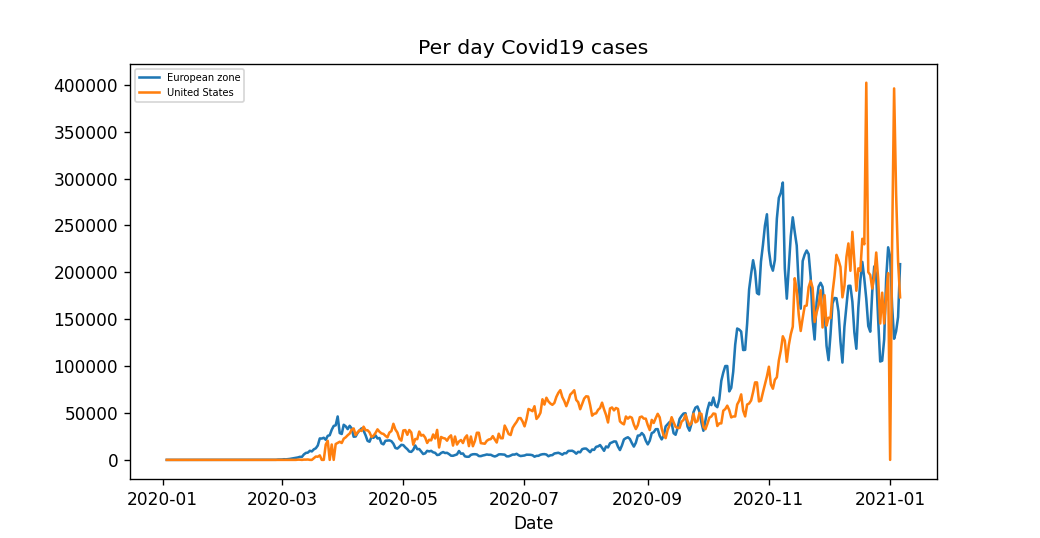

In [24]:
# prepare plot
title = "Per day Covid19 cases"
x_label = "Date"

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(cases_dates, confirmed, label="European zone")
ax.plot(cases_dates, usconfirmed, label="United States")
ax.set_title(title)
ax.set_xlabel(x_label)
ax.legend(loc='upper left', fontsize='xx-small')
plt.show()


<IPython.core.display.Javascript object>


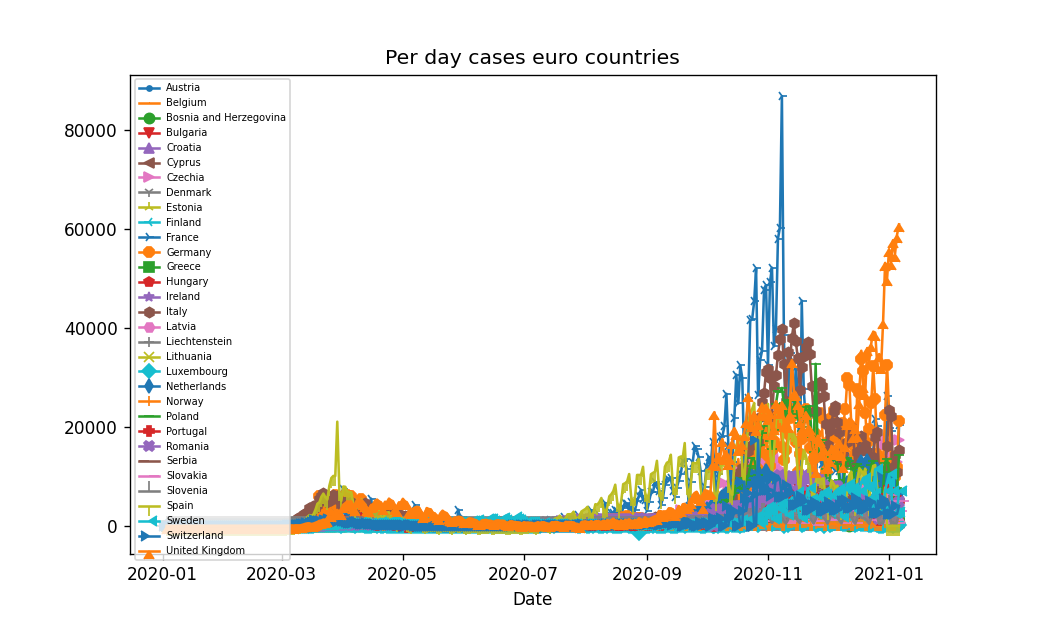

In [18]:
ax = plt.subplot(111)

markers_available = list(Line2D.markers.keys())
marker_idx = -1
for j in full_data["countries"]:
    if full_data["countries"][j]["region"] == "america":
        continue

    country = full_data["countries"][j]["country_name"]
    # print("Working on %s" % country)

    curr_confirmed = []
    curr_data = full_data["countries"][j]["cases"]
    for i in curr_data:
        curr_confirmed.append(curr_data[i][0])

    # Handle individual markers
    marker_idx = marker_idx + 1
    ax.plot(cases_dates, curr_confirmed, label=country, marker=markers_available[marker_idx])

ax.set_title("Per day cases euro countries")
ax.set_xlabel("Date")
ax.legend(loc='upper left', fontsize='xx-small')
plt.show()


In [ ]:
# plot last 30 days euro zone
ax = plt.subplot(111)

curr_len = len(cases_dates)
marker_idx = -1
for j in full_data["countries"]:
    if full_data["countries"][j]["region"] == "america":
        continue

    country = full_data["countries"][j]["country_name"]
    # print("Working on %s" % country)

    curr_confirmed = []
    curr_data = full_data["countries"][j]["cases"]
    for i in curr_data:
        curr_confirmed.append(curr_data[i][0])

    # Handle individual markers
    marker_idx = marker_idx + 1
    ax.plot(cases_dates[curr_len-30:curr_len], curr_confirmed[curr_len-30:curr_len],
            label=country, marker=markers_available[marker_idx])

ax.set_title("Per day cases euro countries; last 30 days")
ax.set_xlabel("Date")
ax.legend(loc='upper left', fontsize='xx-small')
plt.show()


In [ ]:
# display current numpy printoptions
print(np.get_printoptions())

# set precision to 3
np.set_printoptions(precision=3)


In [ ]:
# morbidity ... chance to get sick dependent on the population
# mortality ... chance to die dependent on the population (in our case ignoring the time component of mortality)
# lethality ... chance to die dependent on the sick population

In [ ]:
use_date = list(euro_cases["cases"].keys())[-1]
curr_cases = copy.deepcopy(full_data["countries"])

euro_stat = euro_cases["cases"][use_date]
us_stat = curr_cases["us"]["cases"][use_date]
names = ["Europe", "United states"]

aggregated = list()
aggregated.append(euro_stat)
aggregated.append(us_stat)

for i in curr_cases:
    if curr_cases[i]["region"] == "america":
        continue
    country = curr_cases[i]["country_name"]
    # print("Working on %s" % country)

    names.append(country)
    aggregated.append(curr_cases[i]["cases"][use_date])

labels = ["cases", "cumulative", "morbidity [% pop]", "deaths", "cumulative", "mortality [‰ pop]"]


In [ ]:

# individual country plot
ax = plt.subplot(111)

country_code = "at"

country_data = []
curr_data = full_data["countries"][country_code]
country_name = curr_data["country_name"]
for i in curr_data["cases"]:
    country_data.append(curr_data["cases"][i][0])

ax.plot(cases_dates, country_data)

ax.set_title("Per day cases in %s/%s" % (country_code, country_name))
ax.set_xlabel("Date")
plt.show()


In [ ]:
# individual country bar plot
country_code = "at"

country_data = []
curr_data = full_data["countries"][country_code]
country_name = curr_data["country_name"]
for i in curr_data["cases"]:
    country_data.append(curr_data["cases"][i][0])

fig, ax = plt.subplots()
ax.bar(cases_dates, country_data, 0.8)
ax.set_title("Per day cases in %s/%s" % (country_code, country_name))
ax.set_xlabel("Dates")

plt.show()


In [ ]:
# different stats
sum_only = list()
use_date = list(euro_cases["cases"].keys())[-1]
sum_only_cases = copy.deepcopy(full_data["countries"])

# format large numbers with comma as 1000 separator
def format_country_stats(sum_only, cases, population):
    curr_stat = copy.deepcopy(cases)
    curr_pop = copy.deepcopy(population)
    format_pop = f'{curr_pop:,}'
    curr_case_sum = f'{curr_stat[1]:,}'
    curr_case_per = f'{curr_stat[2]:,}'
    curr_death_sum = f'{curr_stat[4]:,}'
    curr_death_per = f'{curr_stat[5]:,}'
    curr_mortality = f'{round((curr_stat[4]/(curr_stat[1]/100)),3):,}'
    sum_only.append([format_pop, curr_case_sum, curr_case_per, curr_death_sum, curr_death_per, curr_mortality,
                    curr_pop, curr_stat[1], curr_stat[4]])

# Europe sum
format_country_stats(sum_only, euro_cases["cases"][use_date], euro_cases["population"])
# US
format_country_stats(sum_only, sum_only_cases["us"]["cases"][use_date], sum_only_cases["us"]["population"])
names = ["Europe", "United states"]

# Euro countries
for i in sum_only_cases:
    if sum_only_cases[i]["region"] == "america":
        continue
    format_country_stats(sum_only, sum_only_cases[i]["cases"][use_date], sum_only_cases[i]["population"])
    names.append(sum_only_cases[i]["country_name"])


In [ ]:
from pandas import DataFrame as PanDataFrame

# Using pandas to print table sorted by perc population descending
d_sum_only = {}

idx = 0
for curr_list in sum_only:
    d_sum_only[names[idx]] = curr_list
    idx = idx + 1

col_labels = ["population", "sum_cases", "morbidity [% pop]", "sum_deaths", "mortality [‰ pop]", "lethality", 
              "sort_pop", "sort_case", "sort_dead"]
sum_frame = PanDataFrame(d_sum_only, col_labels)

# 0 ... pop, 1 ... sum, 2 ... morbid, 3 ... sum_d, 4 ... mort, 5 ... leth, 6 ... pop_sort, 7 ... case_sort, 8 ... dead_sort
sum_frame.transpose().sort_values(by=col_labels[2], ascending=False).style.hide_columns(["sort_pop", "sort_case", "sort_dead"])


In [ ]:
# calc sum infections last seven days
days = list(full_data["countries"]["at"]["cases"].keys())[-8:-1]

curr_data = {}
curr_plot = {}
for ccode in full_data["countries"]:
    access_data = full_data["countries"][ccode]
    curr_cases = {}

    sum_cases = 0
    for i in days:
        curr_cases[i] = access_data["cases"][i]
        sum_cases = sum_cases + access_data["cases"][i][0]

    perc_cases = round(sum_cases / (access_data["population"]/100), 3)
    curr_data[ccode] = {"country_name": access_data["country_name"],
                        "population": f'{access_data["population"]:,}',
                        "sum_cases": f'{sum_cases:,}',
                        "perc_cases": perc_cases,
                        "cases": copy.deepcopy(curr_cases)
                       }
    curr_plot[access_data["country_name"]] = [f'{access_data["population"]:,}', f'{sum_cases:,}', perc_cases, sum_cases]


In [ ]:
# Add seven days info table
day_col_labels = ["population", "cases last 7 days", "morbidity [% pop]", "sort_cases"]

sum_frame = PanDataFrame(curr_plot, day_col_labels)

sum_frame.transpose().sort_values(by=[day_col_labels[2]], ascending=False).style.hide_columns(["sort_cases"])


In [ ]:
# per day percent plot to properly compare increase rates per citizen
ax = plt.subplot(111)

markers_available = list(Line2D.markers.keys())
marker_idx = -1
curr_len = len(cases_dates)

for j in full_data["countries"]:
    if full_data["countries"][j]["region"] == "america":
        continue

    country = full_data["countries"][j]["country_name"]
    # print("Working on %s" % country)

    population = full_data["countries"][j]["population"]
    curr_per_day_perc = []
    curr_data = full_data["countries"][j]["cases"]
    for i in curr_data:
        curr_val = round(curr_data[i][0]/(population/1000),3)
        curr_per_day_perc.append(curr_val)

    # Handle individual markers
    marker_idx = marker_idx + 1

    ax.plot(cases_dates[curr_len-30:curr_len], curr_per_day_perc[curr_len-30:curr_len], label=country, marker=markers_available[marker_idx])

ax.set_title("Per day morbidity (% pop) increase euro countries (Last 30 days)")
ax.set_xlabel("Date")
ax.legend(loc='upper left', fontsize='xx-small')
plt.show()


In [ ]:
from math import ceil

fig, axs = plt.subplots(int(ceil(len(full_data["countries"])/2)), 2, figsize=(9, 40))

cnt = 0
cntrow = 0
for ctry in full_data["countries"]:
    tmp_data = []
    for day in full_data["countries"][ctry]["cases"]:
        tmp_data.append(full_data["countries"][ctry]["cases"][day][0])
    axs[cntrow, cnt].plot(cases_dates, tmp_data)
    axs[cntrow, cnt].set_title(full_data["countries"][ctry]["country_name"])
    cntrow = cntrow if cnt < 1 else cntrow + 1
    cnt = cnt + 1 if cnt < 1 else 0

plt.tight_layout(pad=4.0)


In [ ]:
# todo: comparison side by side country plots; last 30 days